# U-Net Convolutional Neural Network (CNN)
# Prediciting a full-sized synthetic & TEM images (+ watershed algorithm)
#### Ross Carmichael
#### 19/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import cv2
from MightyMosaic import MightyMosaic

from scipy import ndimage as ndi

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
model = tf.keras.models.load_model('saved_model/model_2.0_5_epochs')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

# Load in some images to be segmented

In [6]:
def load_data(path, tif=False):
    if tif:
        images = sorted(glob(os.path.join(path, "*.tif")))
        return images
    else:
        images = sorted(glob(os.path.join(path, "*.png")))
        return images

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = image.astype(np.float32)
    #image = np.expand_dims(image, axis=0)

    return image

In [8]:
path = "../full-size/synthetic/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

synthetic_images = [read_image(image) for image in images]
print(synthetic_images[0].shape)

Images: 5
(512, 512, 3)


# Split the full-sized images into mosaics and predict

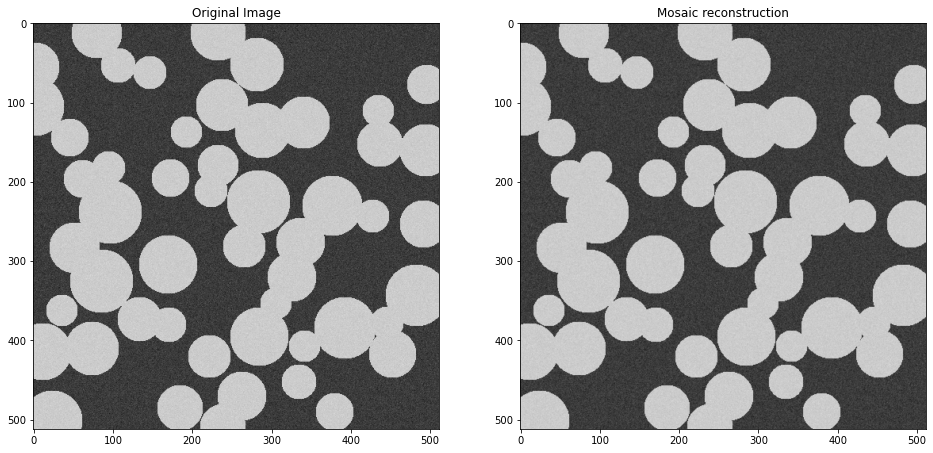

Mosaic shape: (16, 16, 128, 128, 3)


In [10]:
mosaic1 = MightyMosaic.from_array(synthetic_images[2], (128,128), overlap_factor=4, fill_mode='reflect')
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[2])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic1.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic1.shape))

In [11]:
prediction1 = mosaic1.apply(model.predict, progress_bar=True)

In [12]:
fused_prediction1 = prediction1.get_fusion()
labels1 = np.argmax(fused_prediction1, axis=-1)

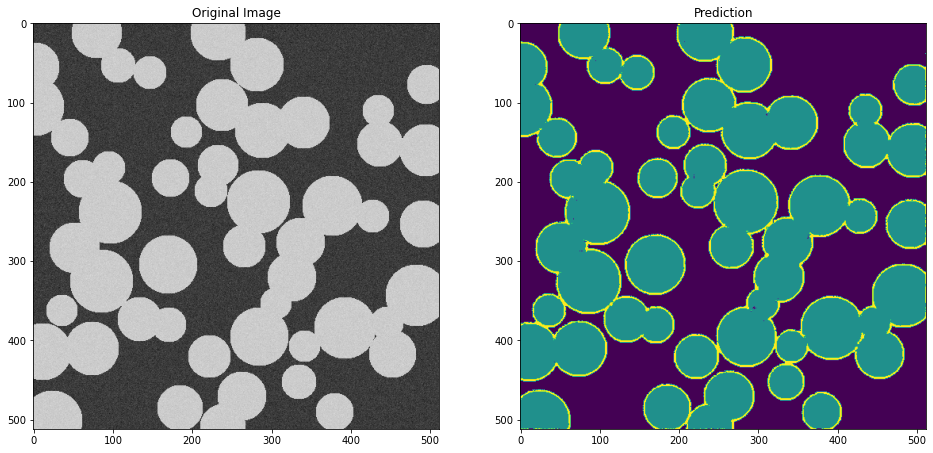

In [14]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[2])

plt.subplot(122)
plt.title("Prediction")
plt.imshow(labels1, interpolation='bilinear')
plt.show()

# Apply the watershed algorithm

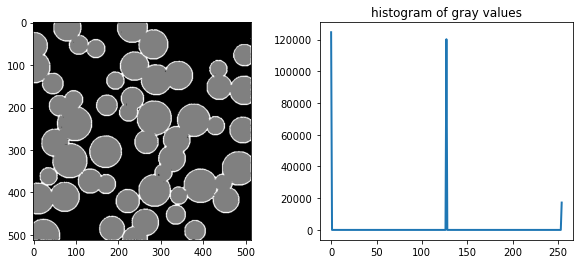

In [15]:
from skimage.exposure import histogram

img = labels1*127

hist, hist_centers = histogram(img)   # generate histogram data for cropped image

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].imshow(img, cmap=plt.cm.gray)   # display cropped image
axes[0].axis('on')
axes[1].plot(hist_centers, hist, lw=2)   # plot histogram
axes[1].set_title('histogram of gray values')
plt.show()

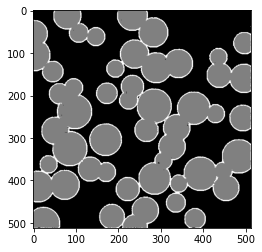

In [16]:
img[img==0] = 255
img[img==255] = 0
img[img==127] = 127

plt.figure(figsize=(8,4))
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [17]:
# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# Clear border remves objects touching the border of the image
from skimage.morphology import area_opening
from skimage.segmentation import clear_border

img = area_opening(img, area_threshold=200)
img = clear_border(img)

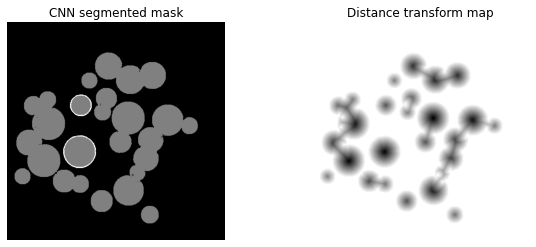

In [18]:
# turn objects into catchment basin using a distance map
dis = ndi.distance_transform_edt(img)
ndis = -dis

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)   # display binary image
axes[0].axis('off')
axes[1].set_title('Distance transform map')
axes[1].imshow(ndis, cmap=plt.cm.gray)   # display distance image
axes[1].axis('off')
plt.show()

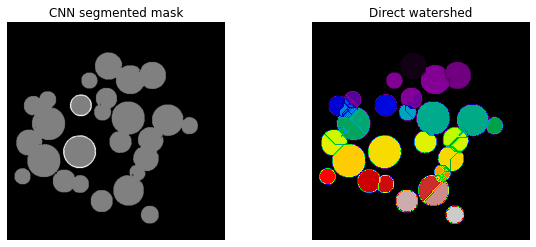

In [19]:
# try direct watershed
from skimage.segmentation import watershed
direct_watershed = watershed(ndis, mask=img, watershed_line=True) 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')

# display watershed image with different colours for different regions
axes[1].set_title('Direct watershed')
axes[1].imshow(direct_watershed, cmap=plt.cm.nipy_spectral)   
axes[1].axis('off')
plt.show()

In [20]:
# generate markers as local maxima in distance map
from skimage.feature import peak_local_max
locedge = 3
locreg  = np.ones((locedge, locedge))
locmax  = peak_local_max(dis, min_distance=3)   # particle centres near local maxima in distance map of eroded image

mask = np.zeros(dis.shape, dtype=bool)   # set up mask with same shape as distance map and pre-populate with False
mask[tuple(locmax.T)] = True   # set mask to True at coordinates of local maxima
markers, num_markers = ndi.label(mask, structure=None,)   # labels objects in mask, False or 0 is considered background
print("Number of markers     = {}".format(num_markers))

Number of markers     = 31


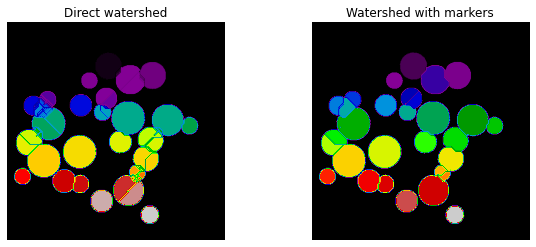

In [21]:
# now do watershed with markers
from skimage.segmentation import watershed
marker_watershed = watershed(ndis, markers=markers, mask=img, watershed_line=True)   # watershed and label image

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
axes[0].set_title('Direct watershed')
axes[0].imshow(direct_watershed, cmap=plt.cm.nipy_spectral)   # display binary image
axes[0].axis('off')
axes[1].set_title('Watershed with markers')
axes[1].imshow(marker_watershed, cmap=plt.cm.nipy_spectral)   # display watershed image with different colours for different regions
axes[1].axis('off')
plt.show()

In [22]:
# get region properties
from skimage.measure import regionprops
regprop = regionprops(marker_watershed)

# Loop through regprop and append area of each labeled object to list.
particles = []
for i in range(len(regprop)):
    yc   = regprop[i].centroid[0]
    xc   = regprop[i].centroid[1]
    area = regprop[i].area
    particles.append([yc,xc,area])

<ipython-input-24-eed6b7323ea8>:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=2.0)


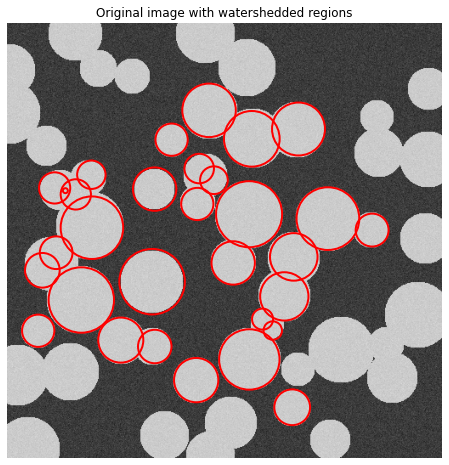

In [24]:
# check whether correct particles found by drawing particle centers
from matplotlib.patches import Circle
from math import sqrt, pi

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')

# Show the image
ax.imshow(synthetic_images[2], cmap=plt.cm.gray)
ax.set_title('Original image with watershedded regions')

# Now, loop through coord arrays, and create a circle at each x,y pair
rr = 1
for item in particles:
    xc = item[1]
    yc = item[0]
    rr = sqrt(item[2]/pi)
    circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=2.0)
    ax.add_patch(circ)

    # Show the image
plt.axis('off')
plt.show()

# Try with real TEM images now

In [26]:
path = "../full-size/tem/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

tem_images = [read_image(image) for image in images]
print(tem_images[0].shape)

tem_images = [1-img for img in tem_images]

Images: 8
(4096, 4096, 3)


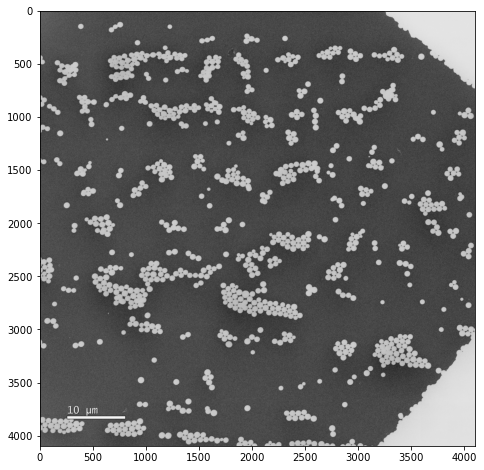

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(tem_images[0])
plt.show()

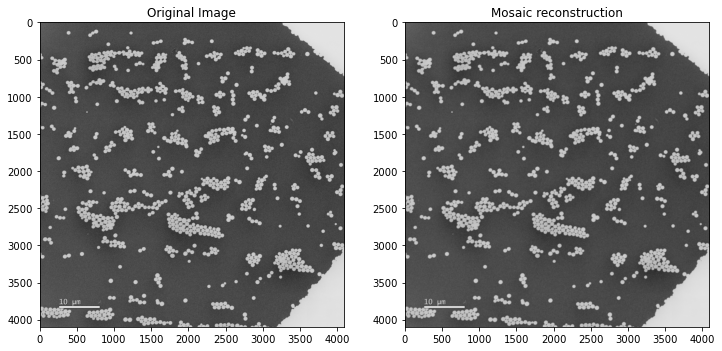

Mosaic shape: (64, 64, 128, 128, 3)


In [28]:
mosaic2 = MightyMosaic.from_array(tem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(tem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic2.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic2.shape))

In [29]:
prediction2 = mosaic2.apply(model.predict, progress_bar=True)

In [30]:
fused_prediction2 = prediction2.get_fusion()
labels2 = np.argmax(fused_prediction2, axis=-1)

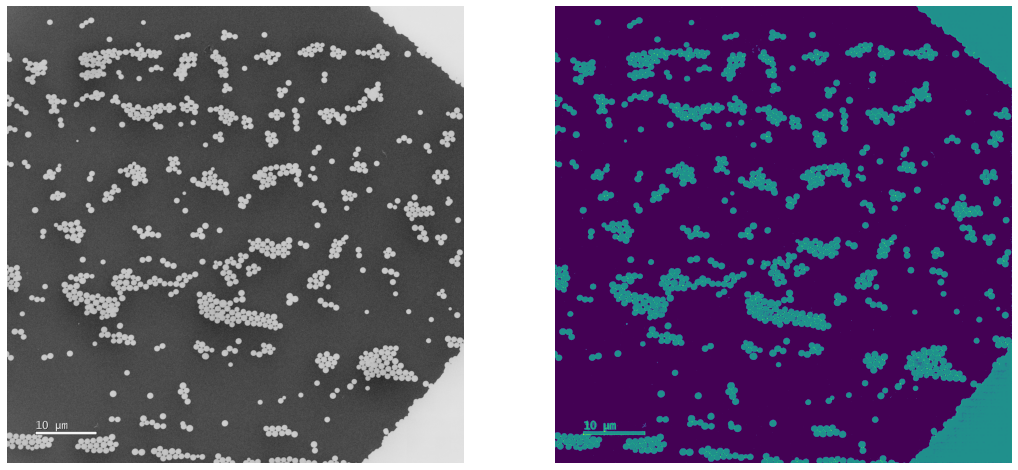

In [31]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(tem_images[0])
axs[0].axis('off')
axs[1].imshow(labels2)
axs[1].axis('off')
plt.show()

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels2*127)
plt.show()

# Apply the watershed algorithm 

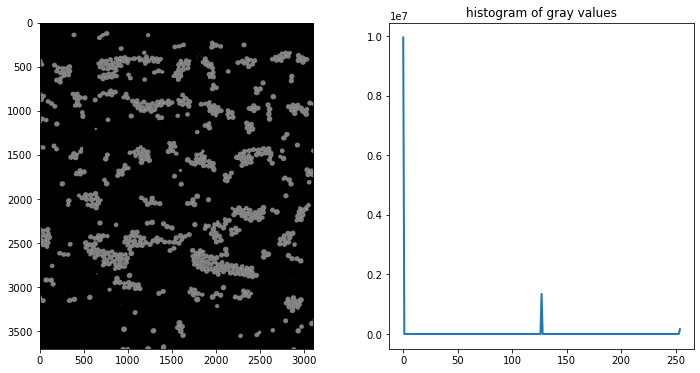

In [32]:
from skimage.exposure import histogram

# Crop to remove the sample plate
img = labels2[0:3700:,0:3100]*127
hist, hist_centers = histogram(img)   # generate histogram data for cropped image

fig, axes = plt.subplots(1, 2, figsize=(12, 6))   # create figure with two sub-plots
axes[0].imshow(img, cmap=plt.cm.gray)   # display cropped image
axes[0].axis('on')
axes[1].plot(hist_centers, hist, lw=2)   # plot histogram
axes[1].set_title('histogram of gray values')
plt.show()

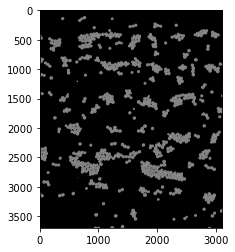

In [33]:
img[img==0] = 255
img[img==255] = 0
img[img==127] = 127
plt.figure(figsize=(8,4))
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [34]:

# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# Clear border remves objects touching the border of the image
from skimage.morphology import area_opening
from skimage.segmentation import clear_border

img = area_opening(img, area_threshold=200)
img = clear_border(img)

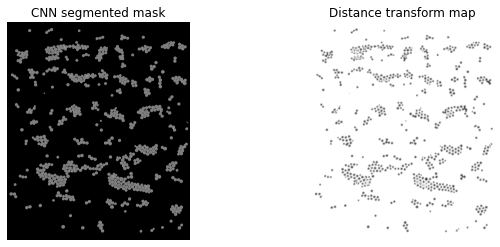

In [35]:
# turn objects into catchment basin using a distance map
dis = ndi.distance_transform_edt(img)
ndis = -dis

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)   # display binary image
axes[0].axis('off')
axes[1].set_title('Distance transform map')
axes[1].imshow(ndis, cmap=plt.cm.gray)   # display distance image
axes[1].axis('off')
plt.show()

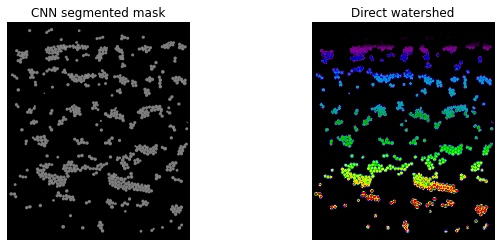

In [36]:
# try direct watershed
from skimage.segmentation import watershed
direct_watershed = watershed(ndis, mask=img, watershed_line=True) 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')

# display watershed image with different colours for different regions
axes[1].set_title('Direct watershed')
axes[1].imshow(direct_watershed, cmap=plt.cm.nipy_spectral)   
axes[1].axis('off')
plt.show()

In [37]:
# generate markers as local maxima in distance map
from skimage.feature import peak_local_max
locedge = 3
locreg  = np.ones((locedge, locedge))
locmax  = peak_local_max(dis, min_distance=3)   # particle centres near local maxima in distance map of eroded image

mask = np.zeros(dis.shape, dtype=bool)   # set up mask with same shape as distance map and pre-populate with False
mask[tuple(locmax.T)] = True   # set mask to True at coordinates of local maxima
markers, num_markers = ndi.label(mask, structure=None,)   # labels objects in mask, False or 0 is considered background
print("Number of markers     = {}".format(num_markers))

Number of markers     = 1016


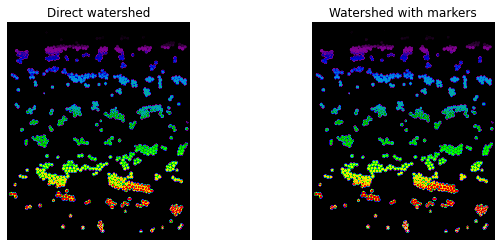

In [38]:
# now do watershed with markers
from skimage.segmentation import watershed
marker_watershed = watershed(ndis, markers=markers, mask=img, watershed_line=True)   # watershed and label image

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
axes[0].set_title('Direct watershed')
axes[0].imshow(direct_watershed, cmap=plt.cm.nipy_spectral)   # display binary image
axes[0].axis('off')
axes[1].set_title('Watershed with markers')
axes[1].imshow(marker_watershed, cmap=plt.cm.nipy_spectral)   # display watershed image with different colours for different regions
axes[1].axis('off')
plt.show()

In [39]:
# get region properties
from skimage.measure import regionprops
regprop = regionprops(marker_watershed)

# Loop through regprop and append area of each labeled object to list.
particles = []
for i in range(len(regprop)):
    yc   = regprop[i].centroid[0]
    xc   = regprop[i].centroid[1]
    area = regprop[i].area
    particles.append([yc,xc,area])

<ipython-input-40-7f21e1a04c33>:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=0.5)


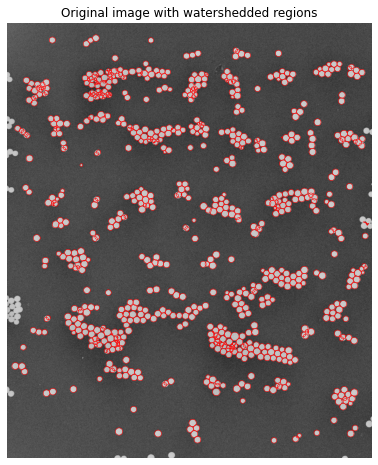

In [40]:
# check whether correct particles found by drawing particle centers
from matplotlib.patches import Circle
from math import sqrt, pi

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')

# Show the image
ax.imshow(tem_images[0][0:3700:,0:3100], cmap=plt.cm.gray)
ax.set_title('Original image with watershedded regions')

# Now, loop through coord arrays, and create a circle at each x,y pair
rr = 1
for item in particles:
    xc = item[1]
    yc = item[0]
    rr = sqrt(item[2]/pi)
    circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=0.5)
    ax.add_patch(circ)

    # Show the image
plt.axis('off')
plt.savefig("watershed_" + name[:-4] + ".svg")
plt.show()

Text(0, 0.5, 'count')

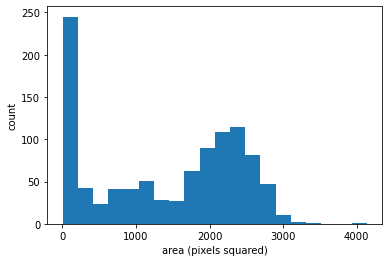

In [41]:
# plot histogram of radii
areas = []
for item in particles:
    area = item[2]
    areas.append(area)

# plot image histogram
areas_array = np.array(areas)

plt.hist(areas_array,bins=20)
plt.xlabel("area (pixels squared)")
plt.ylabel("count")

# Run all TEM images through 

In [15]:
# for i, tem_image in enumerate(tem_images):
#     print(str(i+1) + ' of ' + str(len(tem_images)))
    
#     # Mosaic and predict
#     mosaic = MightyMosaic.from_array(tem_image, (128,128), overlap_factor=2, fill_mode='reflect')
#     prediction = mosaic.apply(model.predict, progress_bar=True)
    
#     clear_output()
    
#     # Fuse and get labels
#     fused_prediction = prediction.get_fusion()
#     labels = np.argmax(fused_prediction, axis=-1)

#     name = os.path.split(images[i])[-1]
    
#     cv2.imwrite("segmented_" + name[:-4] + ".tif", labels*127)

# Run an SEM image through prediction

In [77]:
path = "./full-size/sem/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

sem_images = [read_image(image) for image in images]
print(sem_images[0].shape)

sem_images = [1-img for img in sem_images]

Images: 10
(1920, 2560, 3)


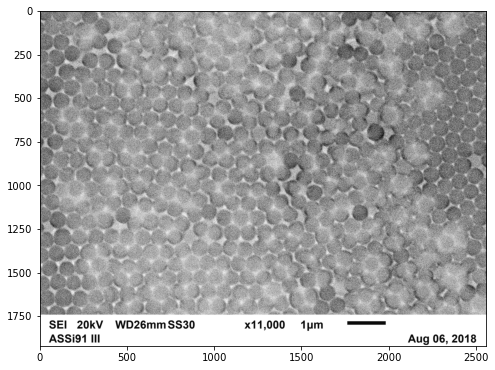

In [78]:
plt.figure(figsize=(8,8))
plt.imshow(sem_images[0])
plt.show()

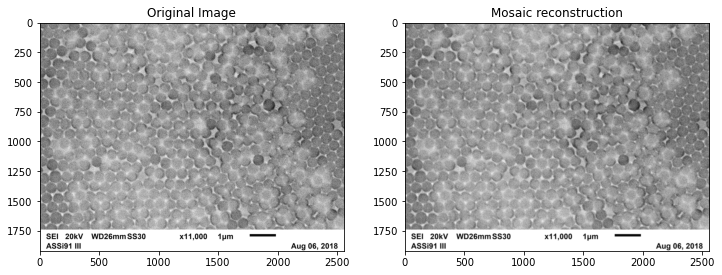

Mosaic shape: (30, 40, 128, 128, 3)


In [79]:
mosaic3 = MightyMosaic.from_array(sem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(sem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic3.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic3.shape))

In [80]:
prediction3 = mosaic3.apply(model.predict, progress_bar=True)

In [81]:
fused_prediction3 = prediction3.get_fusion()
labels3 = np.argmax(fused_prediction3, axis=-1)

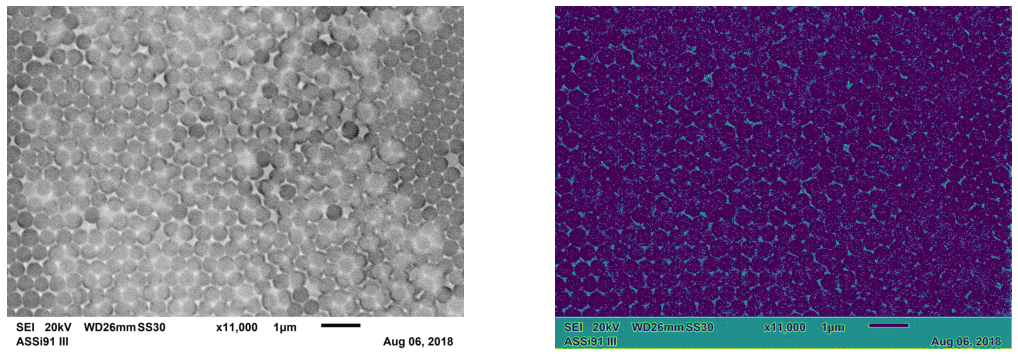

In [82]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(sem_images[0])
axs[0].axis('off')
axs[1].imshow(labels3)
axs[1].axis('off')

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels3*127)
plt.show()